In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

from sentence_transformers import SentenceTransformer, util
from transformers import CLIPModel, AutoTokenizer, AutoProcessor
import evaluate
import pandas as pd

from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from models import GNet8_Encoder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']

print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0
PID of this process = 6180
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1


In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "final_subj01_pretrained_40sess_24bs"
    mode = "imagery"
    all_recons_path = f"evals/{model_name}/{model_name}_all_enhancedrecons_{mode}.pt"
    subj = 1
    
    data_path = "../dataset"
    cache_dir = "../cache"
    
    print("model_name:", model_name)

    jupyter_args = f"--model_name={model_name} --subj={subj} --data_path={data_path} --cache_dir={cache_dir} --all_recons_path={all_recons_path} --mode {mode}"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: final_subj01_pretrained_40sess_24bs
--model_name=final_subj01_pretrained_40sess_24bs --subj=1 --data_path=../dataset --cache_dir=../cache --all_recons_path=evals/final_subj01_pretrained_40sess_24bs/final_subj01_pretrained_40sess_24bs_all_enhancedrecons_imagery.pt --mode imagery


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--all_recons_path", type=str,
    help="Path to where all_recons.pt is stored",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Evaluate on which subject?",
)
parser.add_argument(
    "--mode",type=str,default="vision",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--reps",type=int,default=1,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
if seed > 0 and rep == 1:
    # seed all random functions, but only if doing 1 rep
    utils.seed_everything(seed)

# Evals

In [4]:
if mode == "synthetic":
    all_images = torch.zeros((284, 3, 714, 1360))
    all_images[:220] = torch.load(f"{data_path}/nsddata_stimuli/stimuli/nsdsynthetic/nsd_synthetic_stim_part1.pt")
    #The last 64 stimuli are slightly different for each subject, so we load these separately for each subject
    all_images[220:] = torch.load(f"{data_path}/nsddata_stimuli/stimuli/nsdsynthetic/nsd_synthetic_stim_part2_sub{subj}.pt")
else:
    all_images = torch.load(f"{data_path}/nsddata_stimuli/stimuli/imagery_stimuli_18.pt")

In [5]:
if rep == 1:
    print("all_recons_path:", all_recons_path)
    all_recons = torch.load(all_recons_path)

    # Residual submodule
    all_clipvoxels = torch.load(f"evals/{model_name}/{model_name}_all_clipvoxels_{mode}.pt")
    # Low-level submodule
    if blurry_recon:
        all_blurryrecons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons_{mode}.pt")
else:
    all_recons = torch.load(f"evals/{model_name}/{model_name}_all_recons_{mode}_{rep}reps.pt")
    all_clipvoxels = torch.load(f"evals/{model_name}/{model_name}_all_clipvoxels_{mode}_{rep}reps.pt")
    if blurry_recon:
        all_blurryrecons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons_{mode}_{rep}reps.pt")

# model name
model_name_plus_suffix = f"{model_name}_all_recons_{mode}"
print(model_name_plus_suffix)
print(all_images.shape, all_recons.shape)

all_recons_path: evals/final_subj01_pretrained_40sess_24bs/final_subj01_pretrained_40sess_24bs_all_enhancedrecons_imagery.pt
final_subj01_pretrained_40sess_24bs_all_recons_imagery
torch.Size([12, 3, 425, 425]) torch.Size([12, 3, 256, 256])


In [6]:
# create full grid of recon comparisons
from PIL import Image

imsize = 150
if all_images.shape[-1] != imsize:
    all_images = transforms.Resize((imsize,imsize))(transforms.CenterCrop(all_images.shape[2])(all_images)).float()
if all_recons.shape[-1] != imsize:
    all_recons = transforms.Resize((imsize,imsize))(transforms.CenterCrop(all_images.shape[2])(all_recons)).float()

num_images = all_recons.shape[0]
num_rows = (2 * num_images + 11) // 12

# Interleave tensors
merged = torch.stack([val for pair in zip(all_images, all_recons) for val in pair], dim=0)

# Calculate grid size
grid = torch.zeros((num_rows * 12, 3, all_recons.shape[-1], all_recons.shape[-1]))

# Populate the grid
grid[:2*num_images] = merged
grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 12)]

# Create the grid image
grid_image = Image.new('RGB', (all_recons.shape[-1]*12, all_recons.shape[-1] * num_rows))  # 10 images wide

# Paste images into the grid
for i, img in enumerate(grid_images):
    grid_image.paste(img, (all_recons.shape[-1] * (i % 12), all_recons.shape[-1] * (i // 12)))

grid_image.save(f"../figs/{model_name_plus_suffix}_{len(all_recons)}recons.png")

/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# ground truths, if using NSD-Imagery, we load only the first 12 because the last 6 are conceptual stimuli, for which there was no "ground truth image" to calculate statistics against
if mode != "synthetic":
    all_images = all_images[:12]
    all_recons = all_recons[:12]
    all_clipvoxels = all_clipvoxels[:12]
    if blurry_recon:
        all_blurryrecons = all_blurryrecons[:12]

In [7]:
imsize = 256
if all_images.shape[-1] != imsize:
    all_images = transforms.Resize((imsize,imsize))(all_images).float()
if all_recons.shape[-1] != imsize:
    all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if blurry_recon:
    if all_blurryrecons.shape[-1] != imsize:
        all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
    
if "enhanced" in model_name_plus_suffix and blurry_recon:
    print("weighted averaging to improve low-level evals")
    all_recons = all_recons*.75 + all_blurryrecons*.25

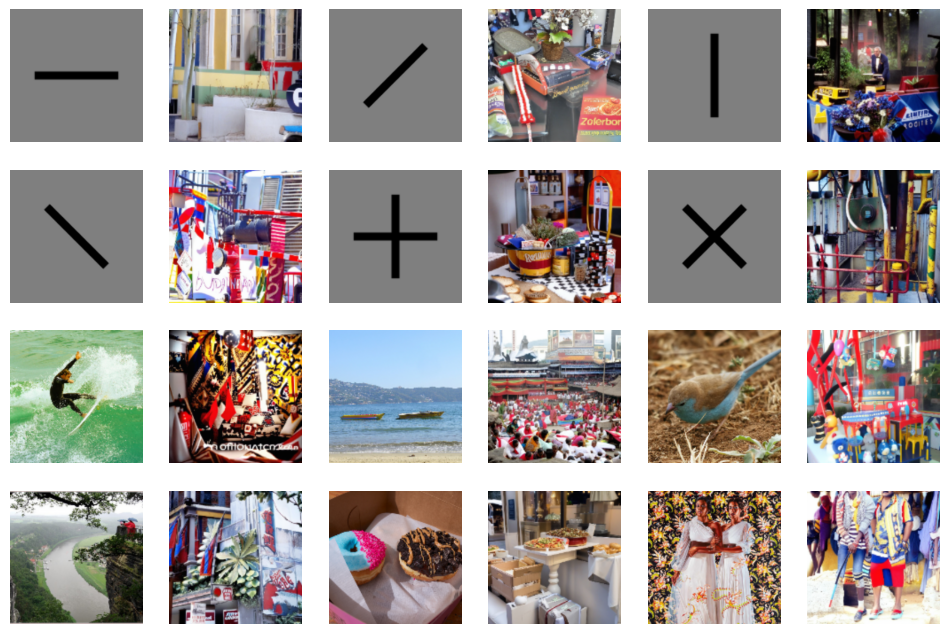

In [8]:
# 2 / 117 / 231 / 164 / 619 / 791
import textwrap
def wrap_title(title, wrap_width):
    return "\n".join(textwrap.wrap(title, wrap_width))

fig, axes = plt.subplots(4,6, figsize=(12,8))
index = 0
for j in range(4):
    for k in range(6):
        if k%2==0:
            axes[j][k].imshow(utils.torch_to_Image(all_images[index]))
            axes[j][k].axis('off')
        else:
            axes[j][k].imshow(utils.torch_to_Image(all_recons[index]))
            axes[j][k].axis('off')
            index +=1

# Retrieval eval

In [9]:
# Load embedding model
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

In [10]:
from scipy import stats
percent_correct_fwds, percent_correct_bwds = [], []
percent_correct_fwd, percent_correct_bwd = None, None

with torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(tqdm(range(30))):
        random_samps = np.random.choice(np.arange(len(all_images)), size=4, replace=False)
        emb = clip_img_embedder(all_images[random_samps].to(device)).float() # CLIP-Image

        emb_ = all_clipvoxels[random_samps].to(device).float() # CLIP-Brain

        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)

        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)

        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

        assert len(bwd_sim) == 4

        percent_correct_fwds = np.append(percent_correct_fwds, utils.topk(fwd_sim, labels,k=1).item())
        percent_correct_bwds = np.append(percent_correct_bwds, utils.topk(bwd_sim, labels,k=1).item())

        if test_i==0:
            print("Loop 0:",percent_correct_fwds, percent_correct_bwds)
            
percent_correct_fwd = np.mean(percent_correct_fwds)
fwd_sd = np.std(percent_correct_fwds) / np.sqrt(len(percent_correct_fwds))
fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

percent_correct_bwd = np.mean(percent_correct_bwds)
bwd_sd = np.std(percent_correct_bwds) / np.sqrt(len(percent_correct_bwds))
bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

 10%|█         | 3/30 [00:00<00:03,  7.47it/s]

Loop 0: [0.5] [0.5]


100%|██████████| 30/30 [00:01<00:00, 15.82it/s]

fwd percent_correct: 0.7500 95% CI: [0.6807,0.8193]
bwd percent_correct: 0.7833 95% CI: [0.6977,0.8689]


Given Brain embedding, find correct Image embedding


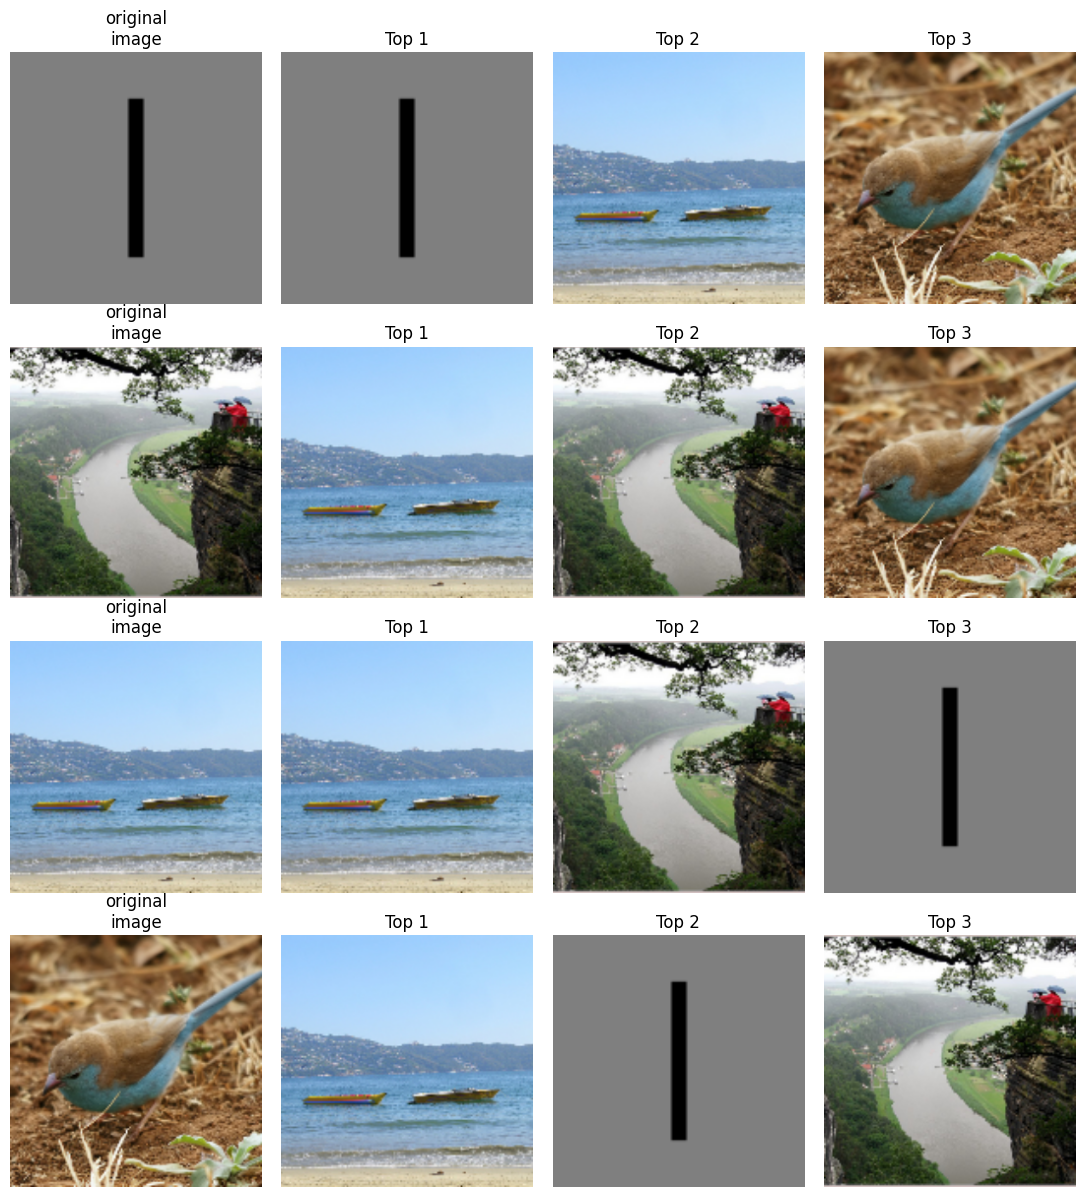

In [11]:
print("Given Brain embedding, find correct Image embedding")
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(all_images[random_samps][trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(3):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(all_images[random_samps][which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

## 2-way identification

In [12]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [13]:
preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_recons_flattened = preprocess(all_recons).view(len(all_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(len(all_images))):
    corrsum += np.corrcoef(all_images_flattened[i], all_recons_flattened[i])[0][1]
corrmean = corrsum / len(all_images)

pixcorr = corrmean
print(pixcorr)

torch.Size([12, 541875])
torch.Size([12, 541875])


100%|██████████| 12/12 [00:00<00:00, 261.32it/s]

0.024101554871404408


## SSIM

In [14]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


converted, now calculating ssim...


100%|██████████| 12/12 [00:00<00:00, 90.46it/s]

0.293463110660151


## AlexNet

In [15]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.5530

---mid, AlexNet(5)---
2-way Percent Correct: 0.5530


/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


## InceptionV3

In [16]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

2-way Percent Correct: 0.5227


/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


## CLIP

In [17]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

2-way Percent Correct: 0.6364


## Efficient Net

In [18]:
import scipy as sp
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool'])
eff_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = eff_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = eff_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",effnet)

Distance: 0.9648230278584721


## SwAV

In [19]:
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool'])
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",swav)

Using cache found in /home/naxos2-raid25/kneel027/.cache/torch/hub/facebookresearch_swav_main
/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/export/raid1/home/kneel027/miniconda3/envs/mindeye2-rel/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.6124638882571158


# Brain Correlation
### Load brain data, brain masks, image lists

In [20]:
if mode == "synthetic":
    voxels, stimulus = utils.load_nsd_synthetic(subject=subj, average=False, nest=True, data_root=data_path)
else:
    voxels, _ = utils.load_nsd_mental_imagery(subject=subj, mode=mode, stimtype="all", average=True, nest=False, data_root=data_path)
    voxels = voxels[:12]
num_voxels = voxels.shape[-1]
num_test = voxels.shape[0]

torch.Size([18, 1, 15724]) torch.Size([18, 3, 425, 425])


In [21]:
# Load brain region masks
brain_region_masks = {}
with h5py.File(f"{cache_dir}/brain_region_masks.hdf5", "r") as file:
    # Iterate over each subject
    for subject in file.keys():
        subject_group = file[subject]
        # Load the masks data for each subject
        subject_masks = {"nsd_general" : subject_group["nsd_general"][:],
                         "V1" : subject_group["V1"][:], 
                         "V2" : subject_group["V2"][:], 
                         "V3" : subject_group["V3"][:], 
                         "V4" : subject_group["V4"][:],
                         "higher_vis" : subject_group["higher_vis"][:]}
        brain_region_masks[subject] = subject_masks
subject_masks = brain_region_masks[f"subj0{subj}"]

# Prepare image list for input to GNet
recon_list = []
for i in range(all_recons.shape[0]):
    img = all_recons[i].detach()
    img = transforms.ToPILImage()(img)
    recon_list.append(img)

### Calculate Brain Correlation scores for each brain area

In [22]:
from torchmetrics import PearsonCorrCoef
GNet = GNet8_Encoder(device=device,subject=subj,model_path=f"{cache_dir}/gnet_multisubject.pt")
PeC = PearsonCorrCoef(num_outputs=len(recon_list))
beta_primes = GNet.predict(recon_list)

region_brain_correlations = {}
for region, mask in subject_masks.items():
    score = PeC(voxels[:,0,mask].moveaxis(0,1), beta_primes[:,mask].moveaxis(0,1))
    region_brain_correlations[region] = float(torch.mean(score))
print(region_brain_correlations)

{'nsd_general': 0.032047469168901443, 'V1': 0.03859696909785271, 'V2': 0.0179253201931715, 'V3': 0.031151285395026207, 'V4': 0.0744866207242012, 'higher_vis': 0.040712833404541016}


In [23]:
# Create a dictionary to store variable names and their corresponding values
import pandas as pd
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV", "FwdRetrieval", "BwdRetrieval",
               "Brain Corr. nsd_general", "Brain Corr. V1", "Brain Corr. V2", "Brain Corr. V3", "Brain Corr. V4",  "Brain Corr. higher_vis"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav, percent_correct_fwd, percent_correct_bwd, 
              region_brain_correlations["nsd_general"], region_brain_correlations["V1"], region_brain_correlations["V2"], region_brain_correlations["V3"], region_brain_correlations["V4"], region_brain_correlations["higher_vis"]]}

df = pd.DataFrame(data)
print(model_name_plus_suffix)
print(df.to_string(index=False))
print(df["Value"].to_string(index=False))

# save table to txt file
os.makedirs('tables/',exist_ok=True)
df["Value"].to_csv(f'tables/{model_name_plus_suffix}.csv', sep='\t', index=False)

final_subj01_pretrained_40sess_24bs_all_recons_imagery
                 Metric    Value
                PixCorr 0.024102
                   SSIM 0.293463
             AlexNet(2) 0.553030
             AlexNet(5) 0.553030
            InceptionV3 0.522727
                   CLIP 0.636364
               EffNet-B 0.964823
                   SwAV 0.612464
           FwdRetrieval 0.750000
           BwdRetrieval 0.783333
Brain Corr. nsd_general 0.032047
         Brain Corr. V1 0.038597
         Brain Corr. V2 0.017925
         Brain Corr. V3 0.031151
         Brain Corr. V4 0.074487
 Brain Corr. higher_vis 0.040713
0.024102
0.293463
0.553030
0.553030
0.522727
0.636364
0.964823
0.612464
0.750000
0.783333
0.032047
0.038597
0.017925
0.031151
0.074487
0.040713
